## Brain Tumor Image Classification

**Studi kasus:**
Dalam proyek ini, dilakukan klasifikasi citra (Image Classification) terhadap dataset citra MRI tumor otak.

Dataset source: https://www.kaggle.com/datasets/briscdataset/brisc2025

**Tahapan:**
* Melakukan EDA terhadap dataset
* Menentukan model klasifikasi citra
* Evaluasi model

In [1]:
import os, random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras

2025-08-05 16:09:30.343334: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-05 16:09:30.343412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-05 16:09:30.379248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-05 16:09:30.432963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-08-05 16:09:35.831066: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-05 16:09:35.894718: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-05 16:09:35.895950: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**Import Dataset**

In [3]:
TRAIN_DIR = "brisc2025/classification_task/train"
TEST_DIR = "brisc2025/classification_task/test"

Penentuan nilai untuk proses klasifikasi

In [4]:
# For Preprocessing
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = len(os.listdir(TRAIN_DIR))

# For Training
BATCH_SIZE = 32
EPOCHS = 16
FOLDS = 5

### Exploratory Data Analysis (EDA)

Visualisasi acak citra dataset beserta kelas/labelnya

In [5]:
def random_visualization(dataset_dir, set_name="Dataset"):
    """
    Visualize random images from the dataset directory.
    """
    classes = os.listdir(dataset_dir)
    fig, axes = plt.subplots(2, 3, figsize=(8, 5))
    fig.suptitle(f"Random Images from {set_name} set", fontsize=16)
    for ax in axes.flatten():
        class_name = random.choice(classes)
        img_files = os.listdir(os.path.join(dataset_dir, class_name))
        img_file = random.choice(img_files)
        img_path = os.path.join(dataset_dir, class_name, img_file)
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(class_name)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

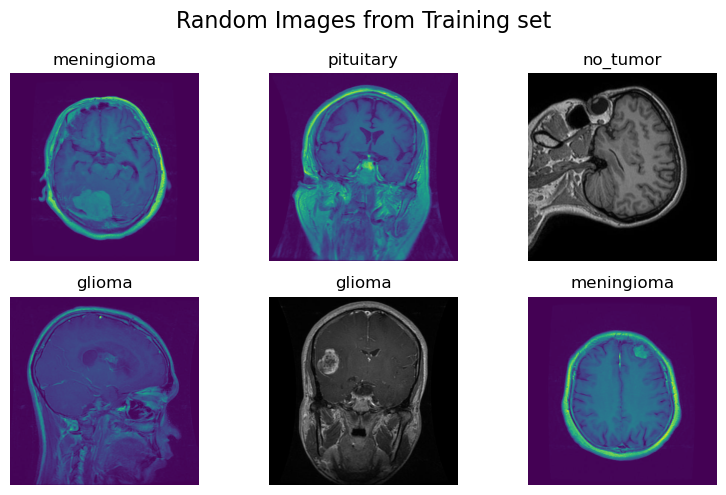

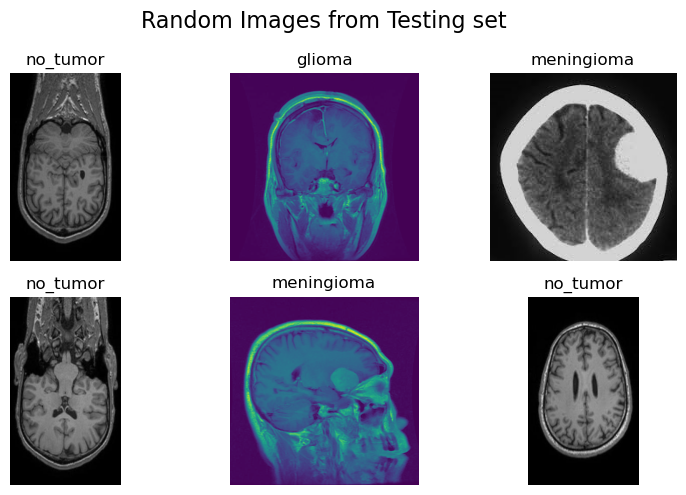

In [6]:
# Random Training Data Visualization
random_visualization(TRAIN_DIR, "Training")

# Random Testing Data Visualization
random_visualization(TEST_DIR, "Testing")

In [7]:
train_img_counts = [len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in os.listdir(TRAIN_DIR)]
test_img_counts = [len(os.listdir(os.path.join(TEST_DIR, cls))) for cls in os.listdir(TEST_DIR)]

Visualisasi distribusi data pada setiap kelas/label data latih dan data uji

In [8]:
def visualize_distribution(dataset_dir, set_name):
    """
    Visualize the distribution of classes in the dataset.
    """
    class_counts = {cls: len(os.listdir(os.path.join(dataset_dir, cls))) for cls in os.listdir(dataset_dir)}
    df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x="Class", y="Count", data=df, width=0.6)
    plt.title(f"Class Distribution in {set_name} Dataset")
    plt.xticks(rotation=45)
    plt.show()

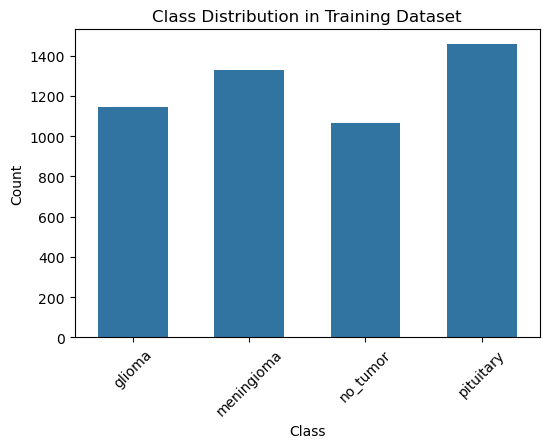

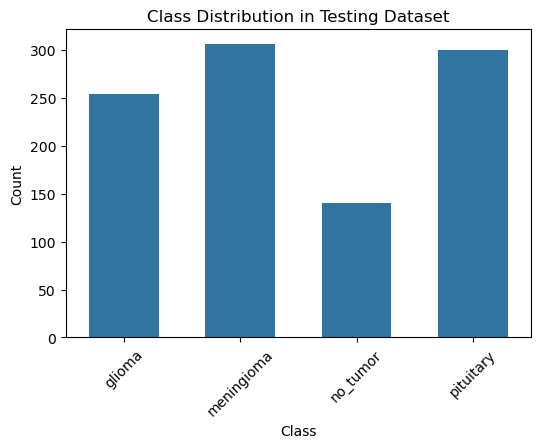

In [9]:
visualize_distribution(TRAIN_DIR, "Training")
visualize_distribution(TEST_DIR, "Testing")

Berdasarkan visualisasi, distribusi data per kelas dataset latih maupun uji tidak seimbang (imbalance)

### Undersampling Imbalance Dataset
Sebelum melakukan preprocessing citra, dilakukan sampling (pengambilan acak) data citra pada setiap kelas dengan undersampling

In [10]:
def undersampling(data_dir, num_samples):
    sample_images = []
    sample_classes = []
    
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        img_names = os.listdir(class_dir)
        img_paths = [os.path.join(class_dir, img_name) for img_name in img_names]
        sample_images.extend(random.sample(img_paths, num_samples))
        sample_classes.extend([class_name] * num_samples)
    
    sample_df = pd.DataFrame({
        "image_path": sample_images,
        "class": sample_classes
    })
    
    return sample_df

In [11]:
main_df = undersampling(TRAIN_DIR, np.min(train_img_counts))
test_df = undersampling(TEST_DIR, np.min(test_img_counts))

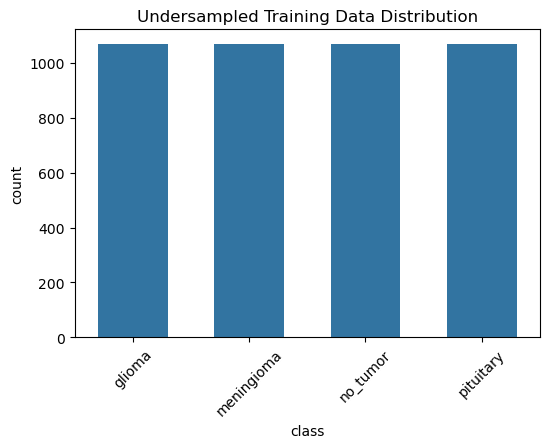

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(data=main_df,
              x="class",
              order=main_df["class"].value_counts().index,
              width=0.6)

plt.title("Undersampled Training Data Distribution")
plt.xticks(rotation=45)
plt.show()

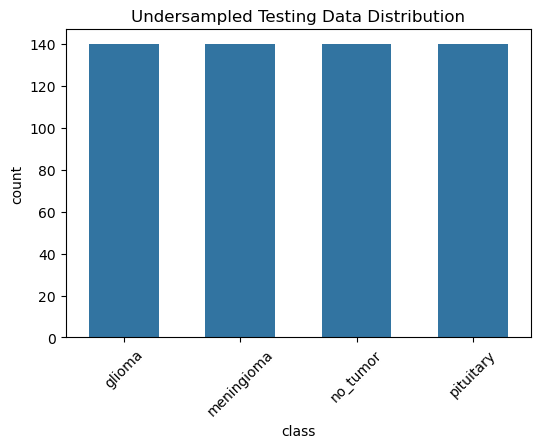

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(data=test_df,
              x="class",
              order=test_df["class"].value_counts().index,
              width=0.6)
plt.title("Undersampled Testing Data Distribution")
plt.xticks(rotation=45)
plt.show()

### Pemodelan
Pembagian dataset yang telah di undersampling (main_df) menjadi data latih dan data validasi

In [14]:
train_df, validation_df = train_test_split(
    main_df,
    test_size=0.2,
    stratify=main_df["class"],
    random_state=42
)

In [15]:
train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)

In [16]:
train_df.nunique()

image_path    3414
class            4
dtype: int64

In [17]:

validation_df.nunique()

image_path    854
class           4
dtype: int64

Pemodelan untuk pelatihan, validasi, dan pengujian

In [18]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

In [19]:
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col=train_df.columns[0],
    y_col=train_df.columns[1],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

validation_gen = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=None,
    x_col=validation_df.columns[0],
    y_col=validation_df.columns[1],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col=test_df.columns[0],
    y_col=test_df.columns[1],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 3414 validated image filenames belonging to 4 classes.
Found 854 validated image filenames belonging to 4 classes.
Found 560 validated image filenames belonging to 4 classes.


In [20]:
model_input = keras.layers.Input(shape=IMG_SHAPE)
layer = keras.layers.Conv2D(32, (3, 3), activation="relu")(model_input)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(64, (3, 3), activation="relu")(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(128, (3, 3), activation="relu")(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Flatten()(layer)
layer = keras.layers.Dense(256, activation="relu")(layer)
layer = keras.layers.Dropout(0.5)(layer)
model_output = keras.layers.Dense(len(train_img_counts), activation="softmax")(layer)

model_final = keras.models.Model(inputs=model_input, outputs=model_output)

model_final.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856 

2025-08-05 16:10:41.288690: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-05 16:10:41.292096: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-05 16:10:41.294653: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Menggunakan callbakcs untuk menghentikan pelatihan dan validasi secara otomatis apabila nilai akurasi validasi berhenti meningkat

In [21]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",
                                               mode="min",
                                               patience=5,
                                               restore_best_weights=True,
                                               verbose=1)

**Pelatihan dan Validasi**

In [22]:
history = model_final.fit(
    train_gen,
    validation_data=validation_gen,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1
)

keras.backend.clear_session()

Epoch 1/16


2025-08-05 16:11:21.371828: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-08-05 16:11:23.460649: I external/local_xla/xla/service/service.cc:168] XLA service 0x72d01d2e7b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-05 16:11:23.460708: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-05 16:11:23.468278: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754385083.563579   27128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/107 [==============================] - 21s 118ms/step - loss: 0.8378 - accuracy: 0.6722 - val_loss: 0.4723 - val_accuracy: 0.8372
Epoch 2/16
107/107 [==============================] - 9s 82ms/step - loss: 0.4064 - accuracy: 0.8515 - val_loss: 0.3413 - val_accuracy: 0.8770
Epoch 3/16
107/107 [==============================] - 9s 83ms/step - loss: 0.2619 - accuracy: 0.9060 - val_loss: 0.2923 - val_accuracy: 0.8923
Epoch 4/16
107/107 [==============================] - 9s 82ms/step - loss: 0.1789 - accuracy: 0.9356 - val_loss: 0.3525 - val_accuracy: 0.9063
Epoch 5/16
107/107 [==============================] - 9s 82ms/step - loss: 0.1455 - accuracy: 0.9441 - val_loss: 0.3030 - val_accuracy: 0.8934
Epoch 6/16
107/107 [==============================] - 9s 83ms/step - loss: 0.1053 - accuracy: 0.9625 - val_loss: 0.2672 - val_accuracy: 0.9087
Epoch 7/16
107/107 [==============================] - 9s 83ms/step - loss: 0.0923 - accuracy: 0.9672 - val_loss: 0.3220 - val_accuracy: 0.9215
Epoch 8/

## Evaluasi Model
* Metrik evaluasi meliputi akurasi, presisi, recall, dan skor F1
* Pengujian model menggunakan data uji bawaan (test set)

In [23]:
test_true = test_gen.classes
test_predicted = model_final.predict(test_gen, verbose=1)

18/18 [==============================] - 2s 116ms/step


Visualisasi matriks hasil prediksi

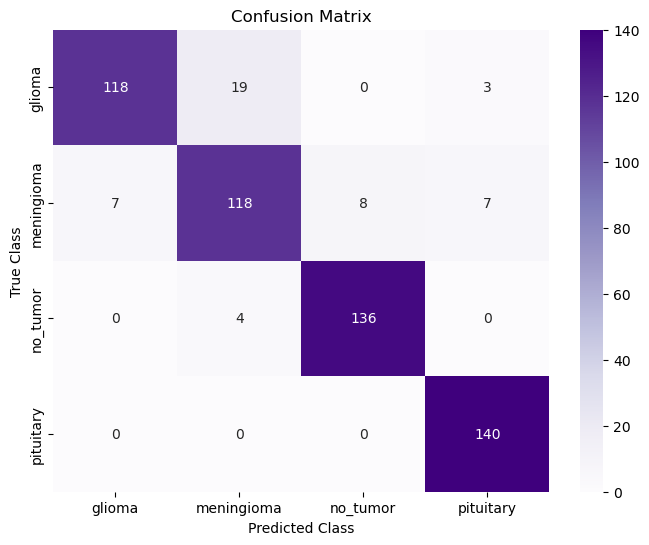

In [24]:
cm_results = confusion_matrix(test_true, np.argmax(test_predicted, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_results, annot=True, fmt="d", cmap="Purples",
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())

plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [25]:
TP = np.diag(cm_results)
FP = np.sum(cm_results, axis=0) - TP
FN = np.sum(cm_results, axis=1) - TP
TN = np.sum(cm_results) - (FP + FN + TP)

accuracy = (TP + TN) / np.sum(cm_results)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

In [26]:
metrics_df = pd.DataFrame({
    "Class": test_gen.class_indices.keys(),
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score
})

metrics_df

,Class,Accuracy,Precision,Recall,F1 Score
0,glioma,0.948214,0.944000,0.842857,0.890566
1,meningioma,0.919643,0.836879,0.842857,0.839858
2,no_tumor,0.978571,0.944444,0.971429,0.957746
3,pituitary,0.982143,0.933333,1.000000,0.965517


Visualisasi nilai setiap metrik evaluasi yang diperoleh pada setiap kelas

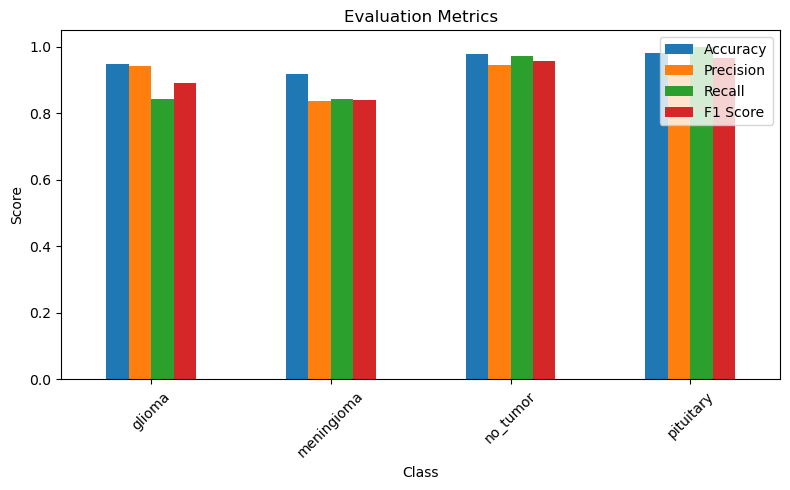

In [27]:
metrics_df.plot(x="Class", y=["Accuracy", "Precision", "Recall", "F1 Score"], kind="bar", figsize=(8, 5))
plt.title("Evaluation Metrics")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()